In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
df = pd.read_csv('Mall_Customers.csv')

In [59]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [60]:
df.shape

(200, 5)

In [61]:
df.corr(numeric_only = True)

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,1.000000,-0.026763,0.977548,0.013835
Age,-0.026763,1.000000,-0.012398,-0.327227
Annual Income (k$),0.977548,-0.012398,1.000000,0.009903
Spending Score (1-100),0.013835,-0.327227,0.009903,1.000000


In [62]:
df['Genre'] = df['Genre'].map({'Male': 0, 'Female':1})

In [63]:
df.corr(numeric_only = True)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,1.000000,-0.057400,-0.026763,0.977548,0.013835
Genre,-0.057400,1.000000,-0.060867,-0.056410,0.058109
Age,-0.026763,-0.060867,1.000000,-0.012398,-0.327227
Annual Income (k$),0.977548,-0.056410,-0.012398,1.000000,0.009903
Spending Score (1-100),0.013835,0.058109,-0.327227,0.009903,1.000000


<Axes: >

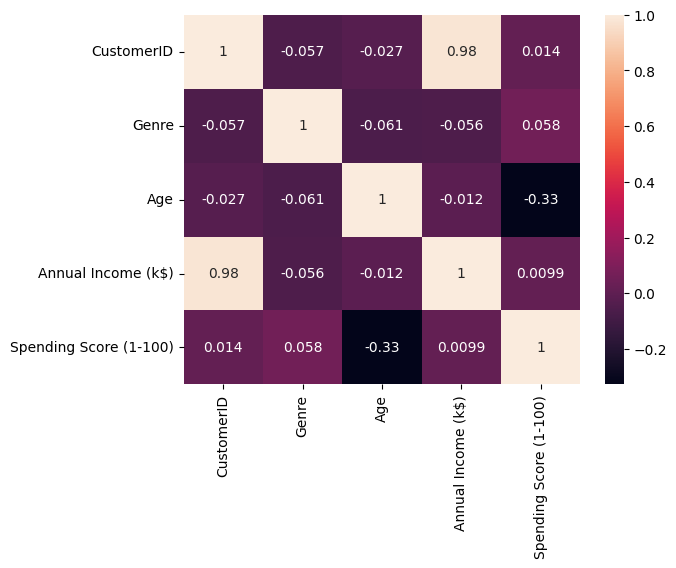

In [64]:
sns.heatmap(df.corr(), annot = True)

In [65]:
df = df.drop('CustomerID', axis=1)

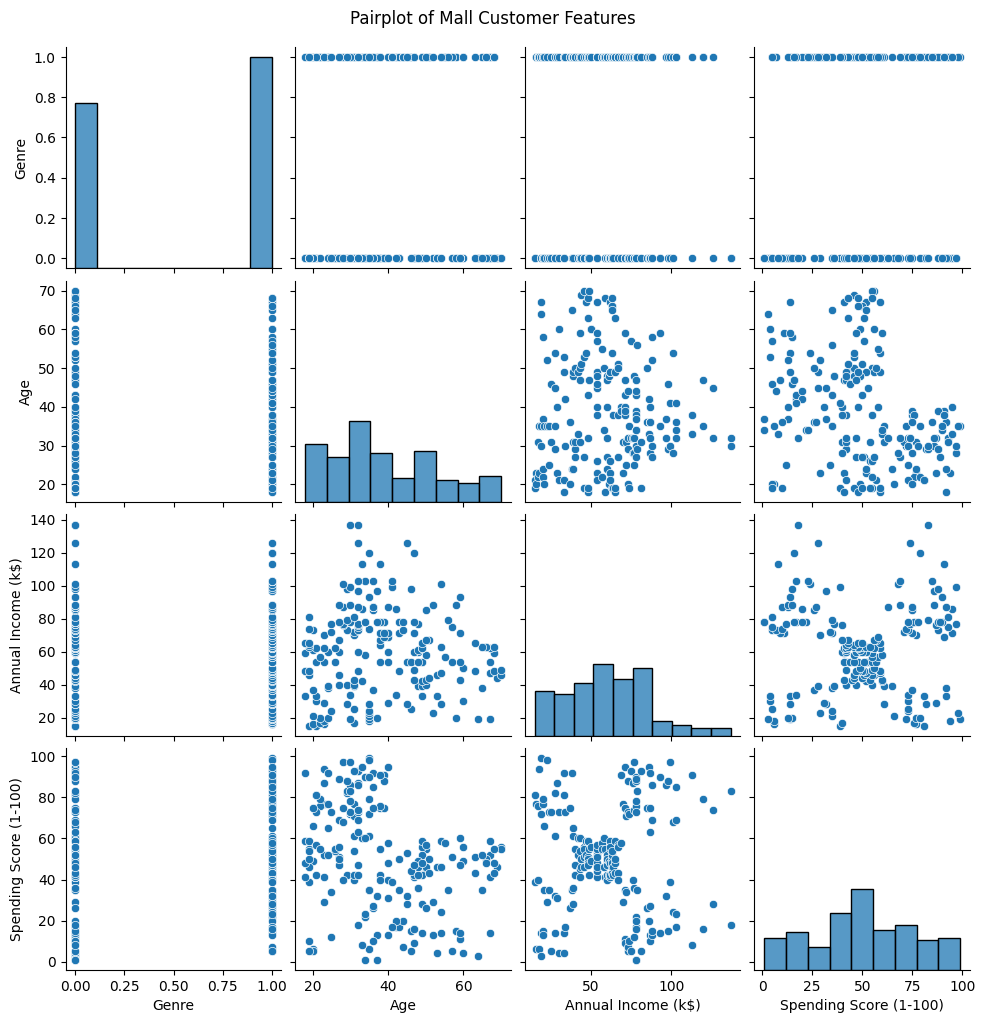

In [66]:
sns.pairplot(df)
plt.suptitle('Pairplot of Mall Customer Features', y=1.02)
plt.show()

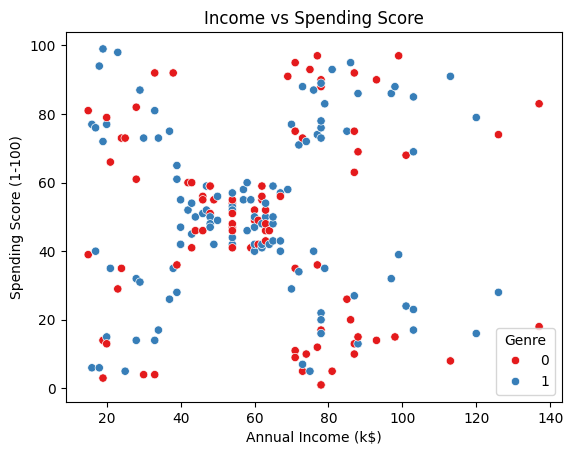

In [67]:
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Genre', palette='Set1')
plt.title('Income vs Spending Score')
plt.show()


In [68]:
# Check for missing values
print(df.isnull().sum())


Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [69]:
df.duplicated().sum()

np.int64(0)

In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

print("Explained Variance Ratios:", pca.explained_variance_ratio_)
print("Total Variance Explained:", sum(pca.explained_variance_ratio_))


Explained Variance Ratios: [0.33690046 0.26230645]
Total Variance Explained: 0.5992069019819846


🔹 Component 1 (PC1):
Explains ~33.7% of the total variance in the data.

This is the most informative single direction (or axis) in your data.

🔹 Component 2 (PC2):
Explains ~26.2% of the total variance.

This is the second most informative direction, orthogonal to PC1.

🔹 Together (PC1 + PC2):
Capture about ~59.9% of the dataset's total variability.

This means we're keeping nearly 60% of the data’s structure while projecting from many dimensions to just 2.



In [72]:
reduced_data.shape

(200, 2)

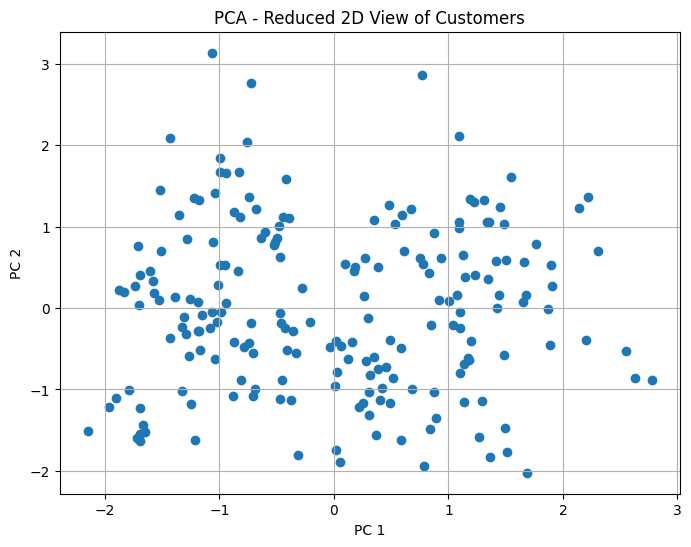

In [73]:
plt.figure(figsize=(8,6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.title('PCA - Reduced 2D View of Customers')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()


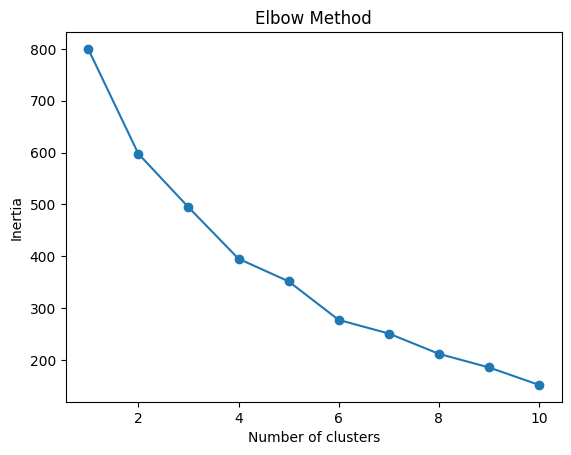

Inertia: [800.0000000000003, 597.9472937932284, 494.8037500130456, 395.3920903479796, 351.7432061711911, 277.3897401985192, 251.15484911190165, 211.98576294959312, 185.72807688711433, 152.02983429775693]


In [74]:
from sklearn.cluster import KMeans

# Elbow method to find optimal K
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()
print("Inertia:", inertia)

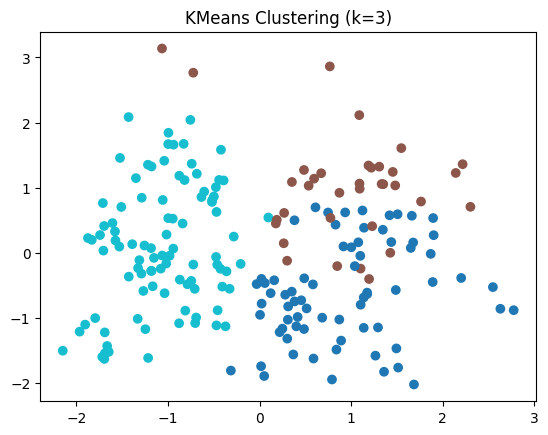

In [120]:
# Based on elbow, let's use k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

# (Optional) visualize
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='tab10')
plt.title('KMeans Clustering (k=3)')
plt.show()


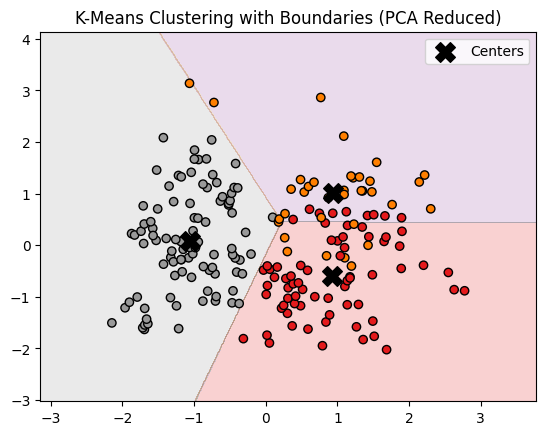

In [121]:


# Get cluster centers in PCA-reduced space
centers = pca.transform(kmeans.cluster_centers_)

# Create meshgrid for background decision boundaries
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predict cluster label for each grid point using inverse PCA → original space → kmeans.predict
inverse_grid = pca.inverse_transform(grid_points)
Z = kmeans.predict(inverse_grid)
Z = Z.reshape(xx.shape)

# Plot decision boundaries
plt.contourf(xx, yy, Z, alpha=0.2, cmap='Set1')

# Plot actual data points
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='Set1', edgecolor='k')

# Plot cluster centers
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='X', label='Centers')

plt.title('K-Means Clustering with Boundaries (PCA Reduced)')
plt.legend()
plt.show()


In [122]:

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import math

best_eps = 0
best_score = -1
best_db_index = math.inf
best_labels = None

for eps in np.arange(0.1, 1.0, 0.1):  # eps from 0.1 to 0.9
    dbscan = DBSCAN(eps=eps, min_samples=2)
    labels = dbscan.fit_predict(scaled_data)

    # Exclude noise (-1) from evaluation
    core_samples_mask = labels != -1
    if len(set(labels[core_samples_mask])) < 2:  # Skip if less than 2 clusters
        continue

    sil_score = silhouette_score(scaled_data[core_samples_mask], labels[core_samples_mask])
    db_index = davies_bouldin_score(scaled_data[core_samples_mask], labels[core_samples_mask])

    if sil_score > best_score and db_index < best_db_index:
        best_score = sil_score
        best_db_index = db_index
        best_eps = eps
        best_labels = labels

print(f"Best eps: {best_eps}")
print(f"Silhouette Score: {best_score}")
print(f"Davies-Bouldin Index: {best_db_index}")
print(f"Number of clusters: {len(set(best_labels)) - (1 if -1 in best_labels else 0)}")


Best eps: 0.1
Silhouette Score: 0.9611133091808268
Davies-Bouldin Index: 0.03764481580359747
Number of clusters: 3


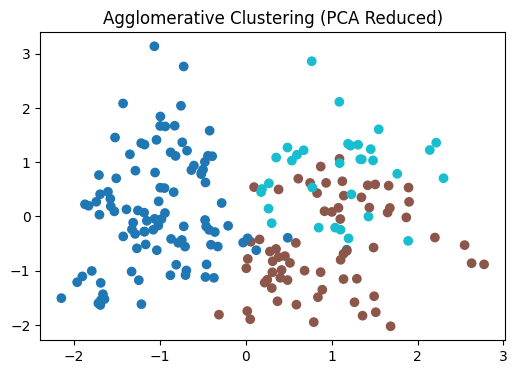

In [123]:
from sklearn.cluster import AgglomerativeClustering

# 1️⃣ Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=3)  # You can change n_clusters based on your data
agglo_labels = agglo.fit_predict(scaled_data)

# 2️⃣ Visualize the clusters (on PCA-reduced data)
plt.figure(figsize=(6, 4))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=agglo_labels, cmap='tab10')
plt.title('Agglomerative Clustering (PCA Reduced)')
plt.show()

In [124]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Silhouette Score (KMeans):", silhouette_score(scaled_data, kmeans_labels))
print("Davies-Bouldin Index (KMeans):", davies_bouldin_score(scaled_data, kmeans_labels))

print("Silhouette Score (DBSCAN):", best_score)
print("Davies-Bouldin Index (DBSCAN):", best_db_index)

print("Silhouette Score (Agglomerative):", silhouette_score(scaled_data, agglo_labels))
print("Davies-Bouldin Index (Agglomerative):", davies_bouldin_score(scaled_data, agglo_labels))


Silhouette Score (KMeans): 0.2576199805135528
Davies-Bouldin Index (KMeans): 1.4248671516594265
Silhouette Score (DBSCAN): 0.9611133091808268
Davies-Bouldin Index (DBSCAN): 0.03764481580359747
Silhouette Score (Agglomerative): 0.24834537795671963
Davies-Bouldin Index (Agglomerative): 1.4513514021782814


For K = 4 <br>
Silhouette Score (KMeans): 0.29010917402310876<br>
Davies-Bouldin Index (KMeans): 1.3055634908016425<br>
Silhouette Score (DBSCAN): 0.12791795612382134<br>
Davies-Bouldin Index (DBSCAN): 2.4806046379247544<br>
Silhouette Score (Agglomerative): 0.26322605188202447<br>
Davies-Bouldin Index (Agglomerative): 1.4019906658555517<br>
For K = 3 <br>
Silhouette Score (KMeans): 0.2576199805135528<br>
Davies-Bouldin Index (KMeans): 1.4248671516594265<br>
Silhouette Score (DBSCAN): 0.17241058408749224<br>
Davies-Bouldin Index (DBSCAN): 2.758845891386849<br>
Silhouette Score (Agglomerative): 0.24834537795671963<br>
Davies-Bouldin Index (Agglomerative): 1.4513514021782814<br><br>
For min_samples = 2 and eps = 0.1 ,k= 3<br>
Silhouette Score (DBSCAN): 0.9611133091808268<br>
Davies-Bouldin Index (DBSCAN): 0.03764481580359747

# ***Conclusion:***
Best Clustering Result: ✅ DBSCAN with eps=0.1 and min_samples=2.

If your goal is to find natural clusters (without specifying k), DBSCAN with proper parameters outperforms others.

If using a fixed k, KMeans with k=4 is your best option.

In [125]:
df['Cluster'] = kmeans_labels
print(df.groupby('Cluster').mean())


            Genre        Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                                 
0        0.605634  52.169014           46.676056               39.295775
1        0.371429  40.228571           91.342857               20.628571
2        0.595745  28.276596           59.585106               69.446809


Cluster 2: Young, mid-income, high spenders — ideal for targeting promotions.

Cluster 1: High income but low spending — could explore why they aren't spending.

Cluster 0: Older, moderate earners with moderate spending — stable but less active.